In [4]:

import corner

import astropy
print('astropy',astropy.__version__ )
from spectral_cube import SpectralCube      # This is a handy package for working with 3D data cubes
from astropy.coordinates import SkyCoord
from reproject import reproject_interp      
from reproject.mosaicking import find_optimal_celestial_wcs 
import regions
import reproject
print('reproject',reproject.__version__)
import spectral_cube
print('spectral_cube',spectral_cube.__version__)
import numpy as np                          
import pylab                                
import matplotlib 
import matplotlib.gridspec as gridspec                                                                                             
import scipy
import astropy.io.fits as fits                                                          
from astropy.wcs import WCS                 
from astropy import units as u              
import pyspeckit as psk   
import astrodendro
import matplotlib.colors as colors
from matplotlib import pyplot as plt
# Suppress warnings we don't care about:
import sys, traceback
import os
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
%matplotlib inline
from matplotlib.patches import Rectangle
#%matplotlib widget
import matplotlib.gridspec as gridspec
################
# MCMC FITTING #
################

###################################################################################################

# import required modules
from matplotlib.gridspec import GridSpec
from scipy.optimize import curve_fit
import scipy.optimize as op
import emcee
import corner


###################################################################################################

# linear fitting function, i.e. two parameter dimensions
def linear(x,a,c):
    return a*x+c

# equivalent power law function
def powlaw(x,a,b):
    return b*np.power(x,a)

# log likelihood
# according to https://ixkael.github.io/fitting-a-line-to-data-a-quick-tutorial/
def lnlikelihood(x, y, xerr, yerr, a, c):

    # only y errors:
    model = linear(x,a,c)
    return -0.5*(np.sum((y-model)**2/yerr**2 - np.log(yerr**2)))

    # # both x and y errors:
    # xyerr = np.sqrt(xerr**2. + yerr**2.)
    # model = linear(x, a, c)
    # return np.sum(-0.5*((y-model)/xyerr)**2 - 0.5*np.log(2*np.pi)-np.log(xyerr))

# negative log likelihood (required to fit maximum likelihood)
# according to https://ixkael.github.io/fitting-a-line-to-data-a-quick-tutorial/
def neg_lnlikelihood(params, x, y, xerr, yerr):
    a, c = params
    return -lnlikelihood(x, y, xerr, yerr, a, c)

# log prior
# simple flat priors on slope and intercept, large range but exclude rediculous values
def lnprior(a,c):
    if ( 0<a<10 ) and ( -10<c<10 ):
        return 0.0
    return -np.inf

# log probability function
# according to https://ixkael.github.io/fitting-a-line-to-data-a-quick-tutorial/
def lnprobability(params, x, y, xerr, yerr):
    a, c = params
    lp = lnprior(a,c)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlikelihood(x, y, xerr, yerr, a, c)


####################################################################################################
# a class to the actual work and fitting
####################################################################################################

class MCMC_fit:

    def __init__(self, x, y, x_err, y_err):
        self.source = None
        self.line   = None
        self.fit    = False
        self.fit_range = [None,None]
        self.x      = np.array(x)
        self.y      = np.array(y)
        self.x_err  = np.array(x_err)
        self.y_err  = np.array(y_err)
        self.ndim = 2
        self.a    = {'ls': None, 'ml': None, 'MCMC': None, 'perc': None}
        self.c    = {'ls': None, 'ml': None, 'MCMC': None, 'perc': None}
        self.nwalkers = 50
        self.nburnin  = 500
        self.nsteps   = 5000
        self.sampler  = None
        self.samples  = None
        self.xlabel   = 'x'
        self.ylabel   = 'y'
        self.figsize  = (6,6)
        self.plotcolor = None
        self.savepath = None

    def mask_bad_values(self):
        print("masking bad values ...")
        good_vals = np.isfinite(self.x) & np.isfinite(self.y) & np.isfinite(self.x_err) & np.isfinite(self.y_err)
        self.x     = self.x[good_vals]
        self.y     = self.y[good_vals]
        self.x_err = self.x_err[good_vals]
        self.y_err = self.y_err[good_vals]

    def restrict_range(self, fit_range=[None,None]):
        self.fit_range = fit_range
        print("restricting fit to "+str(self.fit_range)+" ...")
        if not ( fit_range[0] == None ):
            in_range = self.x > self.fit_range[0]
            self.x     = self.x[in_range]
            self.y     = self.y[in_range]
            self.x_err = self.x_err[in_range]
            self.y_err = self.y_err[in_range]
        if not ( fit_range[1] == None ):
            in_range = self.x < self.fit_range[1]
            self.x     = self.x[in_range]
            self.y     = self.y[in_range]
            self.x_err = self.x_err[in_range]
            self.y_err = self.y_err[in_range]

    # least squares fit
    def least_squares_fit(self):
        print("least squares fitting ...")
        coeff, covar = curve_fit(linear, self.x, self.y, sigma=self.y_err, p0=[1, 1])
        a, c  = coeff
        a_err = covar[0][0]
        c_err = covar[1][1]
        self.a['ls'] = [a,a_err]
        self.c['ls'] = [c,c_err]

    # maximum likelihood fit
    def maximum_likelihood_fit(self):
        print("maximum likelihood fitting ...")
        result = op.minimize(neg_lnlikelihood, [self.a['ls'][0], self.c['ls'][0]], args=(self.x, self.y, self.x_err, self.y_err))
        self.a['ml'], self.c['ml'] = result["x"]

    # run MCMC fit
    def MCMC_fit(self):
        print("Bayesian MCMC fitting ...")
        # initial values for walkers from least squares and maximum likelihood fits
        init_pos = [np.array([self.a['ml'], self.c['ml']]) +1e-2*np.random.randn(self.ndim) for i in range(self.nwalkers)]
        # run MCMC
        self.sampler = emcee.EnsembleSampler(self.nwalkers, self.ndim, lnprobability, args=(self.x, self.y, self.x_err, self.y_err))
        self.sampler.run_mcmc(init_pos, self.nsteps)
        self.samples = self.sampler.chain[:, 50:, :].reshape((-1, self.ndim))
        a_percentiles, c_percentiles = np.percentile(self.samples, [16, 50, 84], axis=0).T
        self.a['MCMC'] = [a_percentiles[1], a_percentiles[2]-a_percentiles[1], a_percentiles[1]-a_percentiles[0]]
        self.c['MCMC'] = [c_percentiles[1], c_percentiles[2]-c_percentiles[1], c_percentiles[1]-c_percentiles[0]]
        self.a['perc'] = [a_percentiles[0], a_percentiles[1], a_percentiles[2]]
        self.c['perc'] = [c_percentiles[0], c_percentiles[1], c_percentiles[2]]

    # plot walkers
    def plot_walkers(self):
        print("plotting walkers ...")
        fig,ax = plt.subplots(2, sharex=True)
        for w in np.arange(self.nwalkers):
            ax[0].plot(self.sampler.chain[w,:,0], color='k', linestyle='-', alpha=0.1)
            ax[1].plot(self.sampler.chain[w,:,1], color='k', linestyle='-', alpha=0.1)
        ax[1].set_xlabel('step')
        ax[0].set_ylabel('slope a')
        ax[1].set_ylabel('intercept c')
        ax[1].set_xlim(0,self.nsteps)
        mkdir(escape_filename(self.savepath))
        fig.savefig(os.path.join(self.savepath, self.source+'.'+self.line+'.walkers.png'), dpi=300, bbox_inches='tight')

    # corner plot
    def corner_plot(self):
        print("plotting parameter distributions ...")
        fig = corner.corner(self.samples, labels=['a', 'c'], quantiles=[0.16, 0.5, 0.84], show_titles=True)
        mkdir(escape_filename(self.savepath))
        fig.savefig(os.path.join(self.savepath, self.source+'.'+self.line+'.corner.png'), dpi=300, bbox_inches='tight')

    # plot x - y relation
    def plot_x_y(self):
        print("plotting x - y relation ...")
        fig,ax = plt.subplots(figsize=self.figsize)
        ax.scatter(np.power(10,self.x), np.power(10,self.y), marker='.', color='k', label='data', s=1, alpha=0.5, zorder=0)
        x = np.logspace(np.min(self.x)-np.log10(1.5), np.max(self.x)+np.log10(1.5), 100)

        # plot most likely
        ax.plot(x, powlaw(x,self.a['MCMC'][0],np.power(10,self.c['MCMC'][0])), lw=1, color="r", zorder=2, label='50 percentile fit')

        # plot random samples
        a, c = self.samples[np.random.randint(len(self.samples), size=1)][0]
        b = np.power(10,c)
        ax.plot(x, powlaw(x,a,b), color="k", alpha=0.1, zorder=2, label='random samples')
        for a, c in self.samples[np.random.randint(len(self.samples), size=10)]:
            b = np.power(10,c)
            ax.plot(x, powlaw(x,a,b), color="k", lw=1, alpha=0.1, zorder=1)

        ax.legend()
        ax.set_xlabel(self.xlabel)
        ax.set_ylabel(self.ylabel)
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlim([0.75*np.power(10,np.min(self.x)),1.5*np.power(10,np.max(self.x))])
        ax.set_ylim([0.75*np.power(10,np.min(self.y)),  1.5*np.power(10,np.max(self.y))])
        mkdir(escape_filename(self.savepath))
        fig.savefig(os.path.join(self.savepath, self.source+'.'+self.line+'.xy.png'), dpi=300, bbox_inches='tight')

    def list_results(self):
        print("\n\n")
        print(self.source+" "+self.line)
        print("  "+'{:>10}{:>10}{:>10}'.format('least sq','max like','MCMC'))
        print("a "+'{:10.6f}{:10.6f}{:10.6f}'.format(self.a['ls'][0], self.a['ml'], self.a['MCMC'][0]))
        print("a-"+'{:10.6f}{:>10}{:10.6f}'.format(  self.a['ls'][1], "",           self.a['MCMC'][1]))
        print("a+"+'{:10.6f}{:>10}{:10.6f}'.format(  self.a['ls'][1], "",           self.a['MCMC'][2]))
        print("c "+'{:10.6f}{:10.6f}{:10.6f}'.format(self.c['ls'][0], self.c['ml'], self.c['MCMC'][0]))
        print("c-"+'{:10.6f}{:>10}{:10.6f}'.format(  self.c['ls'][1], "",           self.c['MCMC'][1]))
        print("c+"+'{:10.6f}{:>10}{:10.6f}'.format(  self.c['ls'][1], "",           self.c['MCMC'][2]))
        print("\n\n")

    def get_y10(self):
        """Calculate y for a scale of 10. This is more meaningful than the intercept (scale=1)."""
        # MCMC
        a  = self.a['perc'][1]
        am = self.a['perc'][0]
        ap = self.a['perc'][2]
        c  = self.c['perc'][1]
        cm = self.c['perc'][0]
        cp = self.c['perc'][2]
        # least squares
        a_ls     = self.a['ls'][0]
        a_ls_err = self.a['ls'][1]
        c_ls     = self.c['ls'][0]
        c_ls_err = self.c['ls'][1]
        y10_ls     = powlaw(10, a_ls, np.power(10,c_ls))
        y10_ls_err = np.log(10)*np.power(10,a_ls+c_ls) *np.sqrt(a_ls_err**2+c_ls_err**2)

        # best fit sigma10
        self.y10 = {'MCMC': [powlaw(10, a, np.power(10,c)), powlaw(10, am, np.power(10,cm)), powlaw(10, ap, np.power(10,cp))],
                    'ls':   [y10_ls, y10_ls_err]}

        # distribution of sigma10
        self.y10s = {'MCMC': [powlaw(10, a, np.power(10,c)) for a, c in self.samples[np.random.randint(len(self.samples), size=100)]]}


####################################################################################################
# fit and plot meta function
####################################################################################################

def fit_MCMC(log_x, log_y, log_x_err, log_y_err, source, line, savepath, xlabel=None, ylabel=None, plotcolor='r', fit_range=[None,None]):
    MCMC = MCMC_fit(log_x, log_y, log_x_err, log_y_err)
    MCMC.savepath = savepath
    MCMC.source   = source
    MCMC.line     = line
    MCMC.plotcolor = plotcolor
    MCMC.xlabel   = xlabel
    MCMC.ylabel   = ylabel

    MCMC.mask_bad_values()
    MCMC.restrict_range(fit_range)
    MCMC.least_squares_fit()
    MCMC.maximum_likelihood_fit()
    MCMC.MCMC_fit()
    MCMC.plot_walkers()
    MCMC.corner_plot()
    MCMC.plot_x_y()
    MCMC.get_y10()
    MCMC.fit = True
    MCMC.list_results()

    return MCMC


####################################################################################################
# print formatted slopes and intercepts
####################################################################################################

def print_formatted(MCMC_list, datatype):
    print(datatype)
    print('{:>8} & {:>10} & {:>6} & {:>6} & {:>6} & {:>6} & {:>6} & {:>6} & {:>8} & {:>8} & {:>8}'.format('source','line','a_16','a_50','a_84','c_16','c_50','c_84','y10','y10 -','y10 +'))
    for m in MCMC_list:
        try:
            print('{:>8} & {:>10} & {:6.2f} & {:6.2f} & {:6.2f} & {:6.2f} & {:6.2f} & {:6.2f} & {:8.1f} & {:8.1f} & {:8.1f}'.format(m.source, m.line, m.a['perc'][0], m.a['perc'][1], m.a['perc'][2], m.c['perc'][0], m.c['perc'][1], m.c['perc'][2], m.y10[0], m.y10[1], m.y10[2]))
        except:
            print('{:>8} & {:>10} & {:<10}'.format(m.source, m.line, 'no fit'))
            
def mkdir(path):
    """mkdir
    Parameters
    ----------
    path : str
        Path to directory to create
    """
    import os
    if ' ' in path:
        raise Exception("Path contains spaces! This will most probably not create the directory you want!")
    if not os.path.exists(path):
        os.system('mkdir -p '+path)
        print("Created "+path)
        
def escape_filename(str):
    """Escape the most often used characters in a string to be used as a file name.
    Parameters
    ----------
    str : str
        Input string to be escaped.
    Returns
    -------
    str
        String with escaped '(', ')'; replaced ' ' by '_' and removed '$'.
        
    """
    str = str.replace('(',r'\(')
    str = str.replace(')',r'\)')
    str = str.replace(' ',r'_')
    str = str.replace('$','')
    return str


def filter_window(x,y,window_min,window_max):
    """select values in the window"""
    x_window = x[(window_min<x) & (x<window_max)]
    y_window = y[(window_min<x) & (x<window_max)]
    return x_window,y_window


def crossmatch(*args):
    """Crossmatch lists for non-finite values.
    Parameters
    ----------
    x : list
    y : list
    ...
    Returns
    -------
    list, list
        Lists in input order with the non-finite (infinite and NaN) values removed from the list and
        also the corresponding element of the other list.
    """
    import numpy as np

    lists = []
    for list in args:
        lists.append( np.array(list) )

    selection = np.isfinite(lists[0])
    for list in lists[1:]:
        selection = selection & np.isfinite(list)

    matched_lists = []
    for list in lists:
        matched_lists.append( list[selection] )

    return matched_lists
def get_binned_percentiles(x_measure, y_measure, x_step, xdata, ydata):

    from astropy.table import Table
    
    

    def filter_window(x,y,window_min,window_max):
        """select values in the window"""
        x_window = x[(window_min<x) & (x<window_max)]
        y_window = y[(window_min<x) & (x<window_max)]
        return x_window,y_window


    # binned percentiles table
    bin_perc = Table(names = ['window min','window center','window max','x 16th','x median','x 84th','y 16th','y median','y 84th'],
                     meta = {'x': x_measure, 'y': y_measure, 'x_step': x_step}
                    )

    x_matched, y_matched = crossmatch(xdata,ydata)

    x_min = np.nanmin(x_matched)
    x_max = np.nanmax(x_matched)
    y_min = np.nanmin(y_matched)
    y_max = np.nanmax(y_matched)

    for log_window_cen in np.arange(np.log10(x_min), np.log10(x_max)+x_step, x_step):
        log_window_min = log_window_cen-x_step/2.
        log_window_max = log_window_cen+x_step/2.
        window_min = np.power(10,log_window_min)
        window_cen = np.power(10,log_window_cen)
        window_max = np.power(10,log_window_max)
        x_window,y_window = filter_window(x_matched,y_matched,window_min,window_max)

        # percentiles only make sense when at least two measurements are available
        if len(x_window)>1:
            x_perc = np.percentile(x_window, [16,50,84])
            y_perc = np.percentile(y_window, [16,50,84])
            bin_perc.add_row( flatten([window_min,window_cen,window_max,x_perc,y_perc]) )

    return bin_perc

    
    
def flatten(x):
    """Flatten list of lists.
    Parameters
    ----------
    x : list,tuple
        List of lists of lists of ...
        Can contain a mixture of lists and values.
    Returns
    -------
    list
        Flattened list.
    """
    import collections
    if isinstance(x, collections.Iterable):
        return [a for i in x for a in flatten(i)]
    else:
        return [x]





astropy 5.1.dev153+gb740594dc
reproject 0.8
spectral_cube 0.6.1.dev22+g003ef16


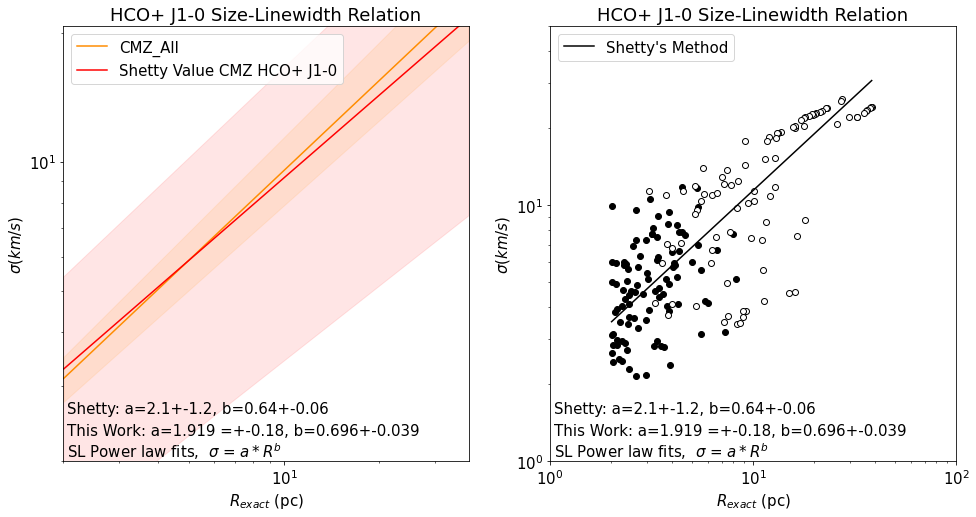

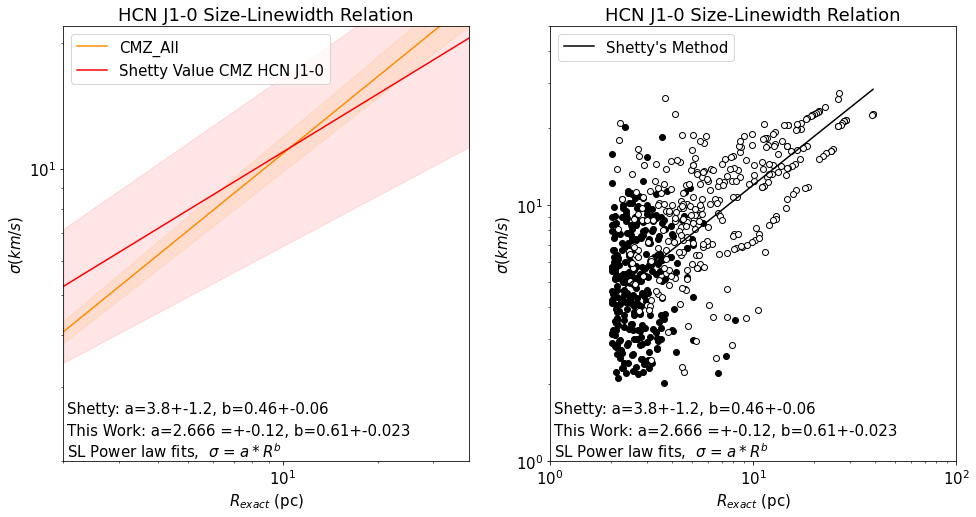

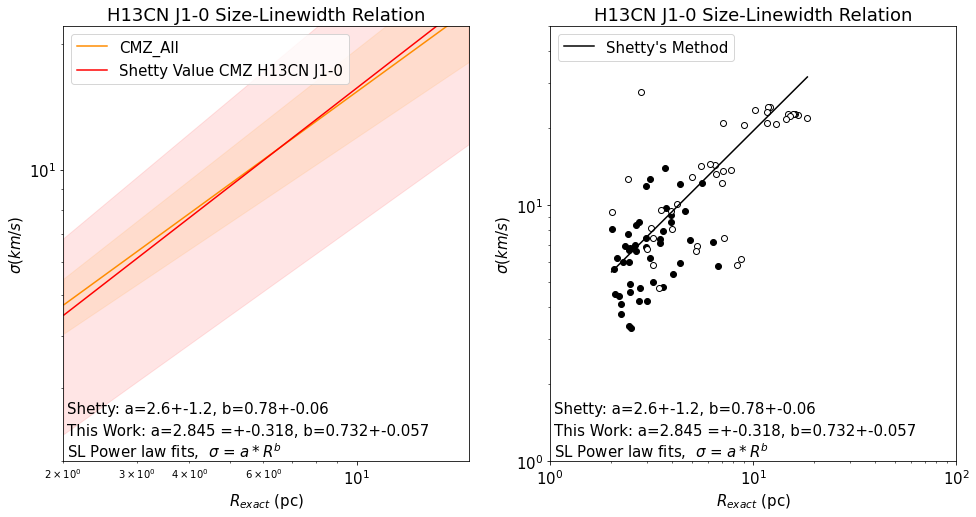

FileNotFoundError: 3RadiiSh_Leaves not found.

In [5]:
#Shetty comparison
Names = np.load("Names_CMZ_Sh.npy")

CMZLs = ["HCO+ J1-0","HCN J1-0","H13CN J1-0","H13CO+ J1-0","CO J3-2"]




#for i in range(len(RNames)):



for i in range(0,5):

    
    #print(RNames,SNames,CMZLs,NGCRNames,NGCSNames)
    
    rname=Names[i]+"Radii"#.npy"
    sname=Names[i]+"Sigmas"#.npy"

    
    #Shetty leaves/branches
    radsBaseSh=[[],[]]
    radsBaseSh[0] = np.genfromtxt(rname+"Sh_Leaves")*10**6#pc
    radsBaseSh[1] = np.genfromtxt(rname+"Sh_Branches")*10**6#pc

    #Shetty leaves/branches
    sigsBaseSh=[[],[]]
    sigsBaseSh[0] = np.genfromtxt(sname+"Sh_Leaves")#km/s
    sigsBaseSh[1] = np.genfromtxt(sname+"Sh_Branches")
   
    #Shetty's method
    radsSh,sigsSh=np.concatenate((radsBaseSh[0],radsBaseSh[1])), np.concatenate((sigsBaseSh[0],sigsBaseSh[1]))
    from scipy.optimize import curve_fit
    
    def func(R,a,b):
        return a*R**(b)
    
    Shetty_Exp = [0.64,0.46,.78,-5,-5]
    Shetty_exp_errs = .06
    
    ShettyCoefs = [2.1,3.8,2.6,-5,-5]
    ShettyCoefsErrs = 1.2
    
    #Sh
    #(poptTSh, pcovTSh) =(curve_fit(func, radsSh,sigsSh,p0=[ShettyCoefs[i],Shetty_Exp[i]]))
    #errs from shetty
    Spatial_Res=np.array([4.3,4.3,4.4,4.4,3])/5#pc
    Spectral_Res=np.array([3.3,3.3,3.3,3.3,2.5])#km/s
    x_err = np.full(np.shape(radsSh), Spatial_Res[i])
    y_err = np.full(np.shape(sigsSh), Spectral_Res[i])
    #(poptTSh, pcovTSh) =(curve_fit(func, radsSh,sigsSh,p0=[ShettyCoefs[i],Shetty_Exp[i]],sigma=y_err))
    (poptTSh, pcovTSh) =(curve_fit(func, radsSh,sigsSh,p0=[ShettyCoefs[i],Shetty_Exp[i]],sigma=np.sqrt(sigsSh)))

    

    
    
    
    fig = plt.figure(1,figsize=(16,8))
    axSh = pylab.subplot(1,2, 1)
    axSh2 = pylab.subplot(1,2, 2)

    
    #sh
    xsSh=np.linspace(np.nanmin(radsSh),np.nanmax(radsSh),50)
    
    
    
    #Shettys method
    er_r=1
    ysTSh=func(xsSh,poptTSh[0],poptTSh[1])
    yusTSh  = func(xsSh, poptTSh[0]+np.sqrt(pcovTSh[0][0])*er_r,poptTSh[1]+np.sqrt(pcovTSh[1][1])*er_r)
    ylsTSh  = func(xsSh, poptTSh[0]-np.sqrt(pcovTSh[0][0])*er_r,poptTSh[1]-np.sqrt(pcovTSh[1][1])*er_r)
    xpaTSh = axSh.plot(xsSh,ysTSh,c='darkorange',label='CMZ_All')
    xpaFTSh = axSh.fill_between(xsSh,ylsTSh,yusTSh,color="Orange",alpha=.1)

    
    #Shetty's methods"
    
    Shetty_Exp = [0.64,0.46,.78,-5,-5]
    Shetty_exp_errs = .06
    
    ShettyCoefs = [2.1,3.8,2.6,-5,-5]
    ShettyCoefsErrs = 1.2
    SP = func(xsSh,ShettyCoefs[i],Shetty_Exp[i])
    SPU = func(xsSh,ShettyCoefs[i]+ShettyCoefsErrs*er_r,Shetty_Exp[i] + Shetty_exp_errs*er_r)
    SPL = func(xsSh,ShettyCoefs[i]-ShettyCoefsErrs*er_r,Shetty_Exp[i] - Shetty_exp_errs*er_r)
    ShettyNM = axSh.plot(xsSh,SP,c='red',label='Shetty Value CMZ '+CMZLs[i])
    ShettyFill = axSh.fill_between(xsSh,SPL,SPU,color="red",alpha=.1)
    
    
    
    #Shetty (data from my runs)
    #The shetty coefs and mine
    stASh= ("This Work: a="+str(round(poptTSh[0],3))+" =+-" + str(round(np.sqrt(pcovTSh[0][0]),3)) +", b="+str(round(poptTSh[1],3))+"+-" + str(round(np.sqrt(pcovTSh[1][1]),3)) )
    ShstASh= ("Shetty: a="+str(round(ShettyCoefs[i],3))+"+-" + str(round(ShettyCoefsErrs,3)) +", b="+str(round(Shetty_Exp[i],3))+"+-" + str(round((Shetty_exp_errs),3)) )
    
    er_r=1
    
    
    
    xpaFTsh2 = axSh2.plot(xsSh,yusTSh,color="Black",alpha=1,label="Shetty's Method")
    
    xpaFTshL = axSh2.scatter(radsBaseSh[0],sigsBaseSh[0],facecolors='Black', edgecolors='Black')
    xpaFTshB = axSh2.scatter(radsBaseSh[1],sigsBaseSh[1],facecolors='White', edgecolors='Black')
    


    axSh2.set_xlabel(r'$R_{exact}$ (pc)',fontsize=15)
    axSh2.set_ylabel(r'$\sigma   (km/s)$',fontsize=15)
    axSh2.set_yscale('log')
    axSh2.set_xscale('log')
    axSh2.annotate(text=r'SL Power law fits,  $\sigma$ = $a*R^b$',fontsize=15,xy=(0.01,0.01),xycoords="axes fraction")
    axSh2.annotate(text=stASh,fontsize=15,xy=(0.01,0.06),xycoords="axes fraction") 
    axSh2.annotate(text=ShstASh,fontsize=15,xy=(0.01,0.11),xycoords="axes fraction") 
    
    axSh2.set_xlim(1,100)
    axSh2.set_ylim(1,50)
    axSh2.set_title((CMZLs[i]+" Size-Linewidth Relation"), fontsize=18)
    axSh2.legend(fontsize=15,loc='upper left')
    #No data fit compare
    
    axSh.set_xlabel(r'$R_{exact}$ (pc)',fontsize=15)
    axSh.set_ylabel(r'$\sigma   (km/s)$',fontsize=15)
    axSh.set_yscale('log')
    axSh.set_xscale('log')
    axSh.annotate(text=r'SL Power law fits,  $\sigma$ = $a*R^b$',fontsize=15,xy=(0.01,0.01),xycoords="axes fraction")
    axSh.annotate(text=stASh,fontsize=15,xy=(0.01,0.06),xycoords="axes fraction") 
    axSh.annotate(text=ShstASh,fontsize=15,xy=(0.01,0.11),xycoords="axes fraction") 
    #axNM.set_xlim(np.nanmin(rads)*.5,np.nanmax(rads)*1)
    axSh.set_xlim(2,np.nanmax(radsSh)*1)
    axSh.set_ylim(2,np.nanmax(sigsSh)*.8)
    axSh.set_title((CMZLs[i]+" Size-Linewidth Relation"), fontsize=18)
    axSh.legend(fontsize=15,loc='upper left')
    axSh.tick_params(axis='both', labelsize=15)
    axSh2.tick_params(axis='both', labelsize=15)
    Save="Shetty_Comps_"+str(i)+".pdf"
    fig.savefig(bbox_inches='tight',fname=Save)
    pylab.show()
    

    
    
    

    